# Wrangle & Analyze Twitter Data from WeRateDogs

In this project we gather, assess and clean data on tweets by WeRateDogs from three sources:

* A given csv file containing an archive of tweets to be analyzed.
* A remotely hosted tsv file containing predictions of dog breed pictured per tweet.
* Data on tweet retweets and favorites obtained via Twitter's API.

We then analyze the data and report findings.

Wrangling activities for this project are limited to assessing and cleaning eight quality issues and two tidiness issues.

In [1]:
import pandas as pd
import numpy as np
import requests
import io
import tweepy
import json
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 1 Gather data

### 1.1 Tweet archive

This given csv just needs to be loaded into a dataframe, direct from the folder.

In [2]:
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### 1.2 Image predictions

This tsv needs to be downloaded from Udacity's servers and loaded into a dataframe. Using the `requests` library rather than reading directly into `pd.read_csv` is a project requirement.

Download the file:

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/' + \
      'August/599fd2ad_image-predictions/image-predictions.tsv'

r = requests.get(url)

Check the encoding:

In [4]:
r.encoding

'utf-8'

Load into a dataframe:

In [5]:
content = io.StringIO(r.content.decode('utf-8'))

df_img_pred = pd.read_csv(content, sep='\t')
df_img_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 1.3 Retweets and favorites

This data needs to be obtained via the Twitter API using tweepy and loaded into a dataframe.

Tweepy requests 100 tweets at a time, so put tweet ids into batches of 100:

In [6]:
n = 100
ids = df_archive['tweet_id'].tolist()
batched = [ids[i:i + 100] for i in range(0, len(ids), 100)]
len(batched)

24

Retrieve data for the batches of tweets from the Twitter API, waiting for 15 min and retrying current batch if there is a rate limit error:

In [7]:
tweets = []
consumer_key = 'ENTER KEY HERE'
consumer_secret = 'ENTER SECRET HERE'
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)
api = tweepy.API(auth)

i = 1
for batch in batched:
    while True:
        try:
            print(f'attempting batch {i}')
            tweets += api.statuses_lookup(batch, trim_user=True)
        except tweepy.RateLimitError:
            print(f'waiting on batch {i}')
            time.sleep(15 * 60)
        else:
            i += 1
            break

attempting batch 1
attempting batch 2
attempting batch 3
attempting batch 4
attempting batch 5
attempting batch 6
attempting batch 7
attempting batch 8
attempting batch 9
attempting batch 10
attempting batch 11
attempting batch 12
attempting batch 13
attempting batch 14
attempting batch 15
attempting batch 16
attempting batch 17
attempting batch 18
attempting batch 19
attempting batch 20
attempting batch 21
attempting batch 22
attempting batch 23
attempting batch 24


Check how many tweets we were able to get data for:

In [8]:
len(tweets)

2331

Save full json data for each tweet to `tweet_json.txt`. This is a project requirement.

In [9]:
with open('tweet_json.txt', 'w', encoding='utf-8') as f:
    for tweet in tweets:
        json.dump(tweet._json, f)
        f.write('\n')

Load tweet ID, retweet count, and favorite count from `tweet_json.txt` into a dataframe. Reading the file line by line is a project requirement.

In [10]:
api_data = []

with open('tweet_json.txt', 'r', encoding='utf-8') as f:
    for l in f.readlines():
        j = json.loads(l)
        api_data.append([j['id'], j['retweet_count'], j['favorite_count']])
        
df_api = pd.DataFrame(api_data, columns=['tweet_id', 'retweets', 'favorites'])
df_api.head()

,tweet_id,retweets,favorites
0,876484053909872640,2117,17378
1,886366144734445568,2823,19484
2,877611172832227328,71,0
3,888078434458587136,3092,20091
4,891689557279858688,7701,38837


### 1.4 Summary

We now have the data in three dataframes as follows:

* `df_archive` contains the tweet data from the given csv file
* `df_img_pred` contains the predictions of dog breed from the downloaded tsv
* `df_api` contains the retweet and favorite data obtained via the Twitter API

## 2 Assess and clean data

Issues are tackled as discovered as many are inter-related. A summary is provided at the end.

### 2.1 One dataframe per observational unit

Examine the dataframes visually, looking at the heads (see above).

Check the number of tweets in each dataframe:

In [11]:
(len(df_archive), len(df_img_pred), len(df_api))

(2356, 2075, 2331)

#### 2.1.1 Assess

* The data is split across three dataframes but they all relate to one type of observational unit (a tweet).
* Data for some tweets is missing from one or more dataframes.

#### 2.1.2 Define

Merge the dataframes on the tweet_id column, using an inner join so we are left only with rows for which we have data from all sources.

#### 2.1.3 Code

In [12]:
df_tidy = df_archive.merge(df_img_pred, on='tweet_id', how='inner') \
                     .merge(df_api, on='tweet_id', how='inner')

#### 2.1.4 Test

Visually inspect dataframe head and columns, and check how many rows are present:

In [13]:
df_tidy.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweets,favorites
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,7512,35537
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,5577,30759
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3693,23122
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7701,38837
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,8297,37103


In [14]:
df_tidy.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweets', 'favorites'],
      dtype='object')

In [15]:
len(df_tidy)

2059

### 2.2 One column per variable

Check mutual exclusivity of `doggo`, `puppo` and `pupper` stages:

In [16]:
sum(df_tidy.apply(lambda r: sum([r['doggo'] != 'None',
                                 r['pupper'] != 'None',
                                 r['puppo'] != 'None']) >= 2, axis=1))

12

Manually investigate why 12 dogs have been given more than one `stage`:

In [17]:
df_tidy['multistage'] = df_tidy.apply(
                            lambda r: sum([r['doggo'] != 'None',
                                           r['pupper'] != 'None',
                                           r['puppo'] != 'None']) >= 2, axis=1)

df_tidy[df_tidy['multistage']==True]['text'].tolist()

["Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel",
 'This is Dido. She\'s playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7',
 'Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho',
 'Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze',
 "This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj",
 "This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd",
 'RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda',
 'RT @dog_rates: This is just do

On some occasions multiple dogs at different stages are featured in the tweet, and on others, a reference to a stage is conversational rather than relating to the dog. There may be other tweets with multiple dogs, both at the same stage. However, a programmatic analysis of the text to unpick these issues is beyond the scope of this project. As the number of occurences with multiple stages is small, they are excluded from the analysis instead.

#### 2.2.1 Assess

* The `doggo`, `pupper`, and `puppo` columns all relate to a single, categorical stage variable (`floofer` is related to fluffiness rather than stage so is regarded as a separate variable).
* Some tweets refer to more than one stage.

#### 2.2.2 Define

1. Drop rows containing more than one stage.
2. Rename `doggo` to `stage`
3. Copy in the value of `pupper` where `stage` is `"None"`
4. Copy in the value of `puppo` where `stage` is still `"None"`
5. Drop `pupper`, `puppo` and `multistage` columns.

#### 2.2.3 Code

In [18]:
to_drop = df_tidy[df_tidy['multistage']==True].index
df_tidy.drop(to_drop, inplace=True)
print(df_tidy['multistage'].value_counts())

df_tidy.rename(columns={'doggo':'stage'}, inplace=True)

df_tidy.loc[df_tidy['stage'] == 'None', ['stage']] = df_tidy['pupper']
df_tidy.loc[df_tidy['stage'] == 'None', ['stage']] = df_tidy['puppo']

df_tidy.drop(columns=['pupper', 'puppo', 'multistage'], inplace=True)

False    2047
Name: multistage, dtype: int64


#### 2.2.4 Test

* Verify that the value count of `multistage` printed above only contains the value `False`.
* Count the values in `stage` to ensure all stages are now represented in this column.
* Check the list of column names to make sure columns were removed.

In [19]:
df_tidy['stage'].value_counts()

None      1748
pupper     210
doggo       66
puppo       23
Name: stage, dtype: int64

In [20]:
df_tidy.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'stage', 'floofer', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'retweets', 'favorites'],
      dtype='object')

### 2.3 Retweets and replies

Count how many tweets are retweets:

In [21]:
df_clean = df_tidy.copy()

len(df_clean[df_clean['retweeted_status_id'].notna()])

70

Count how many tweets are replies:

In [22]:
len(df_clean[df_clean['in_reply_to_status_id'].notna()])

22

Check the content of the replies to make sure they aren't actually ratings we should include in the analysis:

In [23]:
df_clean[df_clean['in_reply_to_user_id'].notna()]['text'].tolist()

['Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen',
 'THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA',
 "PUPDATE: I'm proud to announce that Toby is 236 days sober. Pupgraded to a 13/10. We're all very proud of you, Toby https://t.co/a5OaJeRl9B",
 "PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",
 'Guys... Dog Jesus 2.0\n13/10 buoyant af https://t.co/CuNA7OwfKQ',
 '"Challenge completed" \n(pupgraded to 12/10) https://t.co/85dTK7XCXB',
 'Seriously, add us 🐶 11/10 for sad wet pupper https://t.co/xwPE9faVZR',
 'I found a forest Pipsy. 12/10 https://t.co/mIQ1KoVsmU',
 'Really guys? Again? I know this is a rare Albanian Bingo Seal, but we only rate dogs. Only send in dogs... 9/10 https://t.co/6JYLpUmBrC',
 'If you ar

These replies are mostly invalid for the analysis, and analysing the text to determine which are valid is beyond the scope of this project, so replies are excluded from the analysis.

#### 2.3.1 Assess

The tweets aren't all original tweets - 70 are retweets and 22 are replies.

#### 2.3.2 Define

1. Drop rows where `retweeted_status_id` or `in_reply_to_status_id` is not `NaN`
2. Drop the `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `in_reply_to_status_id`, and `in_reply_to_user_id` columns

#### 2.3.3 Code

In [24]:
to_drop = df_clean[df_clean['retweeted_status_id'].notna() | 
                   df_clean['in_reply_to_status_id'].notna()].index
df_clean.drop(to_drop, inplace=True)
print(f'Retweets {df_clean["retweeted_status_id"].value_counts()}')
print(f'Replies {df_clean["in_reply_to_status_id"].value_counts()}')
df_clean.drop(columns=['retweeted_status_id', 'retweeted_status_user_id',
               'retweeted_status_timestamp', 'in_reply_to_status_id',
               'in_reply_to_user_id'], inplace=True)

Retweets Series([], Name: retweeted_status_id, dtype: int64)
Replies Series([], Name: in_reply_to_status_id, dtype: int64)


#### 2.3.4 Test

* Verify that the value counts for Retweets and Replies printed above are empty series.
* Check the list of column names to make sure columns were removed.

In [25]:
df_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'stage', 'floofer',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweets', 'favorites'],
      dtype='object')

### 2.4 Missing/inaccurate names

Check the value counts of the names column:

In [26]:
df_clean['name'].value_counts()

None        520
a            55
Cooper       10
Oliver       10
Charlie      10
Penny         9
Lucy          9
Tucker        9
Winston       8
Sadie         8
Toby          7
Daisy         7
the           7
Lola          7
Bo            6
Jax           6
Stanley       6
Koda          6
an            6
Bella         6
Leo           5
Louis         5
Bailey        5
Buddy         5
Scout         5
Dave          5
Milo          5
Oscar         5
Rusty         5
Chester       5
           ... 
Kloey         1
Boots         1
Cilantro      1
Tyrone        1
by            1
Carly         1
Stark         1
Shikha        1
Tiger         1
Mona          1
Hazel         1
Bell          1
Jay           1
Billy         1
Theo          1
Mitch         1
Meyer         1
Mimosa        1
Ralphé        1
Kevon         1
Keet          1
Torque        1
Kingsley      1
Harper        1
Dunkin        1
Sparky        1
Quinn         1
Al            1
Kallie        1
Caryl         1
Name: name, Length: 930,

Check a sample where the name is `'None'`:

In [27]:
df_clean[df_clean['name']=='None']['text'].sample(5).tolist()

['Here we have Pancho and Peaches. Pancho is a Condoleezza Gryffindor, and Peaches is just an asshole. 10/10 &amp; 7/10 https://t.co/Lh1BsJrWPp',
 '"Challenge accepted"\n10/10 https://t.co/vNjvr5Bl9u',
 "We only rate dogs. Please don't send in any non-canines like this Floppy Tongued House Panda. Thank you... 12/10 would still pet https://t.co/8fX2VkExnL",
 'I shall call him squishy and he shall be mine, and he shall be my squishy. 13/10 https://t.co/WId5lxNdPH',
 "This pup was carefully tossed to make it look like she's riding that horse. I have no words this is fabulous. 12/10 https://t.co/Bob33W4sfD"]

After checking many samples, it seems that where no name is detected, a high proportion of the tweets relate to invalid tweets for the analysis, such as other animals, or multiple dogs.

Check a sample where the name is `'a'` or `'an'` or `'the'`:

In [28]:
names = ['a', 'an', 'the']
df_clean[df_clean['name'].isin(names)]['text'] \
        .sample(5).tolist()

["This is the best thing I've ever seen so spread it like wildfire &amp; maybe we'll find the genius who created it. 13/10 https://t.co/q6RsuOVYwU",
 'This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2',
 'This is a purebred Bacardi named Octaviath. Can shoot spaghetti out of mouth. 10/10 https://t.co/uEvsGLOFHa',
 'Stop sending in lobsters. This is the final warning. We only rate dogs. Thank you... 9/10 https://t.co/B9ZXXKJYNx',
 "This is a funny dog. Weird toes. Won't come down. Loves branch. Refuses to eat his food. Hard to cuddle with. 3/10 https://t.co/IIXis0zta0"]

After checking many samples, where the name is `'a'` or `'an'` or `'the'` the tweet is usually valid for the analysis, but sometimes not, for example being about another animal.

Analysing the text to determine which tweets with undetected or incorrect name are valid for the analysis is beyond the scope of this project, so these tweets are excluded from the analysis.

#### 2.4.1 Assess

* Some tweets have no dog name detected.
* Some tweets have an incorrect dog name i.e. `'a'`, `'an'` or `'the'`

#### 2.4.2 Define

Drop rows where `name` is `'None'`, `'a'`, `'an'` or `'the'`

#### 2.4.3 Code

In [29]:
names = ['None', 'a', 'an', 'the']
to_drop = df_clean[df_clean['name'].isin(names)].index
df_clean.drop(to_drop, inplace=True)

#### 2.4.4 Test

Check the value counts for the `name` column.

In [30]:
df_clean['name'].value_counts()

Cooper      10
Charlie     10
Oliver      10
Penny        9
Lucy         9
Tucker       9
Winston      8
Sadie        8
Daisy        7
Lola         7
Toby         7
Stanley      6
Jax          6
Bella        6
Koda         6
Bo           6
Milo         5
Rusty        5
Chester      5
Buddy        5
Oscar        5
Louis        5
Dave         5
Scout        5
Bailey       5
Leo          5
Bentley      4
Archie       4
Oakley       4
Clark        4
            ..
by           1
Kollin       1
Taco         1
Einstein     1
Kona         1
Jordy        1
Tripp        1
Obi          1
Torque       1
Jay          1
Billy        1
Theo         1
Mitch        1
Meyer        1
Mimosa       1
Tiger        1
Ralphé       1
Keet         1
Kingsley     1
Carly        1
Harper       1
Dunkin       1
Sparky       1
Quinn        1
Al           1
Kallie       1
Kevon        1
Shikha       1
Stark        1
Caryl        1
Name: name, Length: 926, dtype: int64

### 2.5 Inaccurate rating denominators

Check value counts for `rating_denominator`:

In [31]:
df_clean['rating_denominator'].value_counts()

10     1363
170       1
50        1
11        1
7         1
Name: rating_denominator, dtype: int64

Check tweets where `rating_denominator` is not 10:

In [32]:
df_clean[df_clean['rating_denominator']!=10]['text'].tolist()

['Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx',
 'Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv',
 'This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq',
 'This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5']

The first two don't contain a valid rating and are excluded from analysis. The last two can be manually corrected.

#### 2.5.1 Assess

* Some tweets with `rating_denominator != 10` are invalid for the analysis
* Some tweets with `rating_denominator != 10` have inaccurate but correctable ratings

#### 2.5.2 Define

1. Drop rows with `rating_denominator`s of `170` and `50`
2. Correct ratings for rows with `rating_denominator`s of `11` and `7`

#### 2.5.3 Code

In [33]:
to_drop = df_clean[df_clean['rating_denominator'].isin([7, 170])].index
df_clean.drop(to_drop, inplace=True)

df_clean.loc[df_clean['rating_denominator']==50,
             ['rating_numerator', 'rating_denominator']] = [11, 10]

df_clean.loc[df_clean['rating_denominator']==11,
             ['rating_numerator', 'rating_denominator']] = [10, 10]

#### 2.5.4 Test

Verify that there are no longer any rows with `rating_denominator` of 7, 11, 50 or 170.

In [34]:
df_clean['rating_denominator'].isin([7, 11, 50, 170]).sum()

0

### 2.6 Inacurrate rating numerators

Having seen a tweet mentioning "our first ever 14/10" check tweets where `rating_numerator` is greater than 14:

In [35]:
df_clean[df_clean['rating_numerator']>14]['text'].tolist()

["This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",
 "This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq",
 "This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh"]

The first two instances could be rounded to the nearest integer for analysis. The last instance looks correct and deliberate, but is such a distant outlier it would potentially skew any analysis. Changing this rating to 15/10 would retain the dog's number one rank while allowing analysis to proceed meaningfully.

#### 2.6.1 Assess

* Two numerators are inaccurate due to decimals in the tweet text.
* One numerator is a distant outlier.

#### 2.6.2 Define

1. Round the decimal numerators to the nearest integer and update `rating_numerator`.
2. Reduce the outlier numerator to 15 and update `rating_numerator`.

#### 2.6.3 Code

In [36]:
df_clean.loc[df_clean['rating_numerator']==75, 'rating_numerator'] = 10
df_clean.loc[df_clean['rating_numerator']==27, 'rating_numerator'] = 11
df_clean.loc[df_clean['rating_numerator']==1776, 'rating_numerator'] = 15

#### 2.6.4 Test

Verify that only one `rating_numerator` is greater than 14, and this is 15.

In [37]:
df_clean[df_clean['rating_numerator']>14]['rating_numerator']

789    15
Name: rating_numerator, dtype: int64

### 2.7 Incorrect datatypes

Check the datatype of each column:

In [38]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1365 entries, 0 to 2029
Data columns (total 23 columns):
tweet_id              1365 non-null int64
timestamp             1365 non-null object
source                1365 non-null object
text                  1365 non-null object
expanded_urls         1365 non-null object
rating_numerator      1365 non-null int64
rating_denominator    1365 non-null int64
name                  1365 non-null object
stage                 1365 non-null object
floofer               1365 non-null object
jpg_url               1365 non-null object
img_num               1365 non-null int64
p1                    1365 non-null object
p1_conf               1365 non-null float64
p1_dog                1365 non-null bool
p2                    1365 non-null object
p2_conf               1365 non-null float64
p2_dog                1365 non-null bool
p3                    1365 non-null object
p3_conf               1365 non-null float64
p3_dog                1365 non-null bo

#### 2.7.1 Assess

* `timestamp` is a string rather than a datetime.
* `stage` is a string rather than a category.
* `floofer` is a string rather than a boolean.

#### 2.7.2 Define

1. Convert `timestamp` to a datetime.
2. Convert `stage` to a category.
3. Convert `floofer` to a boolean.

#### 2.7.3 Code

In [39]:
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_clean['stage'] = df_clean['stage'].astype('category')

floof = {'floofer':True, 'None':False}
df_clean['floofer'] = df_clean['floofer'].map(floof)

#### 2.7.4 Test

Check the datatypes again.

In [40]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1365 entries, 0 to 2029
Data columns (total 23 columns):
tweet_id              1365 non-null int64
timestamp             1365 non-null datetime64[ns]
source                1365 non-null object
text                  1365 non-null object
expanded_urls         1365 non-null object
rating_numerator      1365 non-null int64
rating_denominator    1365 non-null int64
name                  1365 non-null object
stage                 1365 non-null category
floofer               1365 non-null bool
jpg_url               1365 non-null object
img_num               1365 non-null int64
p1                    1365 non-null object
p1_conf               1365 non-null float64
p1_dog                1365 non-null bool
p2                    1365 non-null object
p2_conf               1365 non-null float64
p2_dog                1365 non-null bool
p3                    1365 non-null object
p3_conf               1365 non-null float64
p3_dog                1365 non

### 2.8 Unneeded columns

Check the list of columns:

In [41]:
df_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'stage', 'floofer',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweets', 'favorites'],
      dtype='object')

#### 2.8.1 Assess

The following columns are not needed for the analysis: `source`, `expanded_urls`, `jpg_url` and `rating_denominator`.

#### 2.8.2 Define

Drop the columns `source`, `expanded_urls`, `jpg_url` and `rating_denominator`.

#### 2.8.3 Code

In [42]:
df_clean.drop(columns=['source', 'expanded_urls',
                       'jpg_url', 'rating_denominator'], inplace=True)

#### 2.8.4 Test

Check the list of columns.

In [43]:
df_clean.columns

Index(['tweet_id', 'timestamp', 'text', 'rating_numerator', 'name', 'stage',
       'floofer', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweets', 'favorites'],
      dtype='object')

### 2.9 False negatives from image predictions

Check how often the image predications all say it's not a dog:

In [44]:
len(df_clean[(df_clean['p1_dog']==False) & 
             (df_clean['p2_dog']==False) &
             (df_clean['p3_dog']==False)])

168

Check how often tweets are invalid for analysis when the image predications all say it's not a dog:

In [45]:
df_clean[(df_clean['p1_dog']==False) & 
             (df_clean['p2_dog']==False) &
             (df_clean['p3_dog']==False)].sample(5)['text'].tolist()

["This is Archie. He's a Bisquick Taj Mapaw. Too many people are touching him. It is doing him a discomfort. 10/10 https://t.co/CJJpjTMzPQ",
 'This is Mia. She was specifically told not get on top of the hutch or play in the fridge. 10/10 what a rebel https://t.co/3J7wkwW4FG',
 "This is Chesterson. He's a Bolivian Scoop Dog. Incredibly portable. Can't bark for shit tho. 7/10 would still pet https://t.co/EatAd8JhyW",
 "This is Louis. He's crossing. It's a big deal. 13/10 h*ckin breathtaking https://t.co/D0wb1GlKAt",
 "This is Brockly. He's an uber driver. Falls asleep at the wheel often. Irresponsible af 8/10 would totally still pet https://t.co/fn1oUlS69Z"]

After checking many samples, no invalid tweet has been found. No cleaning action is necessary, but this is noted for completeness.

### 2.10 Summary

The following issues were discovered and cleaned:

#### 2.10.1 Tidiness

* The data was split across three dataframes but they all related to one type of observational unit. The dataframes were merged.
* The `doggo`, `pupper`, and `puppo` columns all related to a single, categorical `stage` variable (`floofer` relates to fluffiness rather than stage so was regarded as a separate variable). This information was collated into a single `stage` column.

#### 2.10.2 Quality

* Data for 297 tweets was missing from one or more dataframes. These tweets were removed.
* 12 tweets contained references to multiple stages i.e. `doggo`, `pupper`, `puppo`. These tweets were removed.
* The tweets weren't all original tweets - 70 were retweets and 22 were replies. These tweets were removed.
* Names were not always detected and this often indicated a tweet that didn't rate a single dog. These tweets were removed.
* Detected names were not always accurate - sometimes being picked up as `'a'`, `'an'` or `'the'`. This sometimes indicated a tweet that didn't rate a single dog. These tweets were removed.
* Rating denominators were not always accurate. Ratings were corrected where tweets were valid for the analysis, and otherwise were removed.
* Rating numerator were not always accurate due to decimals used in the tweet. Ratings were rounded to the nearest integer.
* One outlier numerator of 1776 was present. This was reduced to 15, preserving the dog's number one rank within the data.
* `timestamp` was a string rather than a datetime. It was converted.
* `stage` was a string rather than a category. It was converted.
* `floofer` was a string rather than a boolean. It was converted.
* The columns `source`, `expanded_urls`, `jpg_url` and `rating_denominator` were not needed for analysis. These columns were removed.


## 3 Store data

In [46]:
df_clean.to_csv('twitter_archive_master.csv')

## 4 Analyze data

### 4.1 Is there a correlation between rating and favorites?

First, plot a scatterplot of rating against favorites for a quick visual assessment:

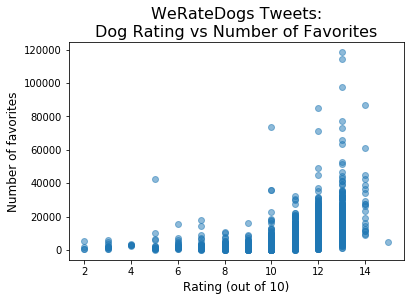

In [47]:
plt.scatter(df_clean['rating_numerator'], df_clean['favorites'], alpha=0.5)
plt.title('WeRateDogs Tweets:\nDog Rating vs Number of Favorites', fontsize=16)
plt.xlabel('Rating (out of 10)', fontsize=12)
plt.ylabel('Number of favorites', fontsize=12);

From the graph above it does seem that the most favorited tweets are for highly rated dogs, but it's difficult to see what's going on for the least favorited tweets.

Try taking log of the number of favorites:

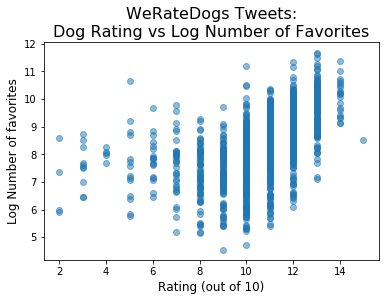

In [48]:
plt.scatter(df_clean['rating_numerator'], np.log(df_clean['favorites']), alpha=0.5)
plt.title('WeRateDogs Tweets:\nDog Rating vs Log Number of Favorites', fontsize=16)
plt.xlabel('Rating (out of 10)', fontsize=12)
plt.ylabel('Log Number of favorites', fontsize=12);

Now we can clearly see that above 10/10, a higher rating is correlated with more favorites. Below 10/10, it looks possible that the rating doesn't make much difference.

### 4.2 Which stage dogs get the best and worst ratings on average?

Plot boxplots of rating grouped by stage:

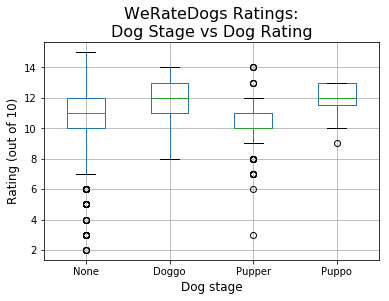

In [49]:
df_clean[['rating_numerator', 'stage']].groupby(df_clean['stage']).boxplot(subplots=False);
plt.title('WeRateDogs Ratings:\nDog Stage vs Dog Rating', fontsize=16)
plt.xlabel('Dog stage', fontsize=12)
plt.ylabel('Rating (out of 10)', fontsize=12)
plt.xticks([1, 2, 3, 4], ['None', 'Doggo', 'Pupper', 'Puppo']);

While it's difficult to separate `Doggo` and `Puppo`dogs for best ratings, surprisingly (for me at least) `Pupper` dogs, the youngest category, get the worst ratings on average.

## 4.3 Which type of dog averaged the most retweets according to the image predictions?

First, put the most confident prediction that is actually a dog into a new column:

In [50]:
df_clean['top_dog_pred'] = 'Unknown'
df_clean.loc[df_clean['p3_dog']==True, 'top_dog_pred'] = df_clean['p3']
df_clean.loc[df_clean['p2_dog']==True, 'top_dog_pred'] = df_clean['p2']
df_clean.loc[df_clean['p1_dog']==True, 'top_dog_pred'] = df_clean['p1']

In [51]:
df_clean['top_dog_pred'].value_counts()

Unknown                       168
golden_retriever              105
Labrador_retriever             72
Pembroke                       71
Chihuahua                      67
pug                            46
toy_poodle                     38
chow                           37
Pomeranian                     29
French_bulldog                 25
malamute                       25
Samoyed                        24
Chesapeake_Bay_retriever       23
cocker_spaniel                 20
Siberian_husky                 19
miniature_pinscher             19
Shih-Tzu                       17
beagle                         16
Staffordshire_bullterrier      16
Cardigan                       16
German_shepherd                15
Old_English_sheepdog           14
Eskimo_dog                     14
Shetland_sheepdog              14
Pekinese                       12
basset                         12
schipperke                     12
kelpie                         11
Italian_greyhound              11
Lakeland_terri

In [52]:
df_clean[['retweets', 'top_dog_pred']].groupby('top_dog_pred') \
        .mean().sort_values(by='retweets', ascending=False)

,retweets
top_dog_pred,
English_springer,10608.500000
standard_poodle,5681.666667
briard,5528.000000
whippet,5178.666667
Afghan_hound,5103.666667
Saluki,5024.666667
French_bulldog,4746.280000
Irish_water_spaniel,3872.000000
cocker_spaniel,3761.200000


The English Springer averaged the most retweets.